In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import boxcox, boxcox_normplot
from sklearn.preprocessing import StandardScaler
from glmnet_python import glmnet
from glmnetPlot import glmnetPlot 
from glmnetPrint import glmnetPrint
from glmnetCoef import glmnetCoef
from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet
from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot
from cvglmnetPredict import cvglmnetPredict
from scipy.special import binom
import itertools  
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, KFold
import os 
if not(os.path.isdir("tarea")):
    mkdir("tarea")
def addInteractions(X,squares=False):
    aux = X.copy()
    interactions = []
    errors = []
    for index1,col1 in enumerate(X.columns):
        if col1 != "const":
            for index2,col2 in enumerate(X.columns[index1:]):
                if col2 != "const" and (col1!=col2 or squares):
                    inter = "{0}:{1}".format(col1,col2)
                    interactions.append(inter)
                    aux[inter] = X[col1]*X[col2]
    return aux
def scaleData(df):
    cat = [var for var in df.columns if not(np.issubdtype(df[var].dtype,np.number))]
    num = df.drop(cat,axis=1)
    # Creating dictionary to store the different data frames
    data = {"original":df}
    # Standarizing data to have mean 0 and variance 1
    scaler = StandardScaler()
    scaler.fit(num)
    data["standarized"] = pd.DataFrame(scaler.transform(num),index=num.index,columns=num.columns)
    data["standarized"][cat] = df[cat]
    data["standarized"] = data["standarized"][df.columns]
    # Centering data to have variance 1 
    scaler = StandardScaler(with_mean=False)
    scaler.fit(num)
    data["withmean"] = pd.DataFrame(scaler.transform(num),index=num.index,columns=num.columns)
    data["withmean"][cat] = df[cat]
    data["withmean"] = data["withmean"][df.columns]
    return data

def drop1(model,X,y,errorFunc):
    base = errorFunc(model,X,y)
    vals = []
    for var in X.columns:
        aux = X.drop(var,axis=1)
        curr = errorFunc(model,aux,y)
        vals.append(curr)
    newInfo = pd.DataFrame.from_dict({"Dropped":X.columns,errorFunc.__name__:vals,"Change":[base - err for err in vals]})
    return newInfo

def dropRecursively(model,X,y,errorFunc,maxiter=10,verbose=False):
    newInfo = drop1(model,X,y,errorFunc)
    variables = X.columns.to_list()
    if verbose:
        print()
        #print(newInfo)
    c = 0
    while newInfo["Change"].max()>0 and c < maxiter:
        droped = newInfo["Dropped"][newInfo["Change"].idxmax()]
        variables.remove(droped)
        newInfo = drop1(model,X[variables],y,errorFunc)
        if verbose:
            #print(newInfo)
            print("Iter = {0}".format(c+1))
            print("Droping {0}".format(droped))
        c += 1
    return X[variables]

def aic(model,X,y):
    mod = model(exog=X,endog=y)
    fit = mod.fit()
    return fit.aic

def bic(model,X,y):
    mod = model(exog=X,endog=y)
    fit = mod.fit()
    return fit.bic

def rss(model,X,y):
    mod = model(exog=X,endog=y)
    fit = mod.fit()
    return fit.ssr

def F_test_P_value(model,X,y):
    mod = model(exog=X,endog=y)
    fit = mod.fit()
    return fit.f_pvalue

def subsetComb(model,X,y,errorFunc,k=3):
    base = errorFunc(model,X,y)
    vals = []
    subsets = [list(sub) for sub in itertools.combinations(X.columns,k)]
    for sub in subsets:
        aux = X[list(sub)]
        val = errorFunc(model,aux,y)
        vals.append(val)
    newInfo = pd.DataFrame.from_dict({"Variables":subsets,errorFunc.__name__:vals,"Change":[base - err for err in vals]})
    return newInfo

def exhaustiveSearch(model,X,y,errorFunc,kmin,kmax,verbose=False):
    infos = []
    print("Sizes:")
    print([binom(X.shape[1],i) for i in range(kmin,kmax+1)])
    for i in range(kmin,kmax+1):
        if verbose:
            print("Trying models with {0} variables".format(i))
        infos.append(subsetComb(model,X,y,errorFunc,k=i))
    return pd.concat(infos,ignore_index=True)

def upwardsSearch(model,X,y,errorFunc,kmin,kmax,verbose=False):
    if verbose:
        print("Selecting initial model")
    info = subsetComb(model,X,y,errorFunc,k=kmin)
    initVars = info["Variables"][info["Change"].idxmax()]
    if verbose:
        print("Selected initial model with {0}".format(initVars))
    X1 = X[initVars].copy()
    c = 0
    while X1.shape[1] < kmax and c<1000:
        if verbose:
            print("Selecting model with {0} variables".format(X1.shape[1]+1))
        baseErr = errorFunc(model,X1,y)
        otherVars = [var for var in X.columns if not(var in X1.columns)] 
        errors = []
        for var in otherVars:
            aux = X1.copy()
            aux[var] = X[var]
            errors.append(errorFunc(model,aux,y))
        bestVar =  otherVars[np.argmin(errors)]
        if verbose:
            print("Adding {0} to model".format(bestVar))
            if baseErr < np.min(errors):
                print("Warning: adding {0} to {1} doesn't decrease {2}".format(bestVar,X1.columns.to_list(),errorFunc.__name__))
        X1[bestVar] = X[bestVar]
        c += 1
    return X1

def summaryGLMnet(glmnetFit):
    if fit1["class"] == 'cvglmnet':
        return pd.DataFrame.from_dict({k:glmnetFit["glmnet_fit"][k] for k in ["df","dev","lambdau"]})
    else:
        return pd.DataFrame.from_dict({k:glmnetFit[k] for k in ["df","dev","lambdau"]})

def kfold(X,y,**kwargs):
    splitter = KFold(**kwargs)
    iterator = splitter.split(X,y)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for train_index, test_index in iterator:
        X_train.append(X.iloc[train_index,:])
        y_train.append(y.iloc[train_index])
        X_test.append(X.iloc[test_index,:])
        y_test.append(y.iloc[test_index])
    return X_train,X_test,y_train,y_test

def labels(X,y,**kwargs):
    labs = np.zeros(X.shape[0],dtype=np.int8)
    for clas, (test_index, train_index) in enumerate(KFold(**kwargs).split(X,y)):
        labs[train_index] = clas
    return labs

In /home/aldo/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/aldo/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/aldo/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /home/aldo/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/aldo/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
df = pd.read_csv("http://vincentarelbundock.github.io/Rdatasets/csv/MASS/Boston.csv",header=0,index_col=0)
resCol = "crim"
df["chas"] = df["chas"].astype("object")
X = scaleData(df)["standarized"]
X["chas"] = X["chas"].astype("int64")
X = addInteractions(X.drop(resCol,axis=1),squares=False)
X = X.reset_index(drop=True)
boxc = boxcox(df[resCol])
print("Lambda value: {0}".format(boxc[1]))
y = boxc[0]
y = pd.Series(y)

Lambda value: -0.1135346104820464


In [3]:
mod = sm.OLS(exog=X,endog=y)
fit = mod.fit()

In [4]:
k=5
n=100
errs = np.zeros(n)
for i in range(n):        
    print("Iter = {0}".format(i+1))
    X_train,X_test,y_train,y_test = kfold(X,y,n_splits=k,shuffle=True)
    temp = np.zeros(k)
    for j in range(k):
        mod = sm.OLS(exog = X_train[j],endog = y_train[j])
        fit = mod.fit()
        temp[j] = sum((fit.predict(X_test[j]) - y_test[j])**2)/X_test[j].shape[0]
    errs[i] = np.mean(temp)
basecverr = np.mean(errs)
basecverrstd = np.std(errs)

Iter = 1
Iter = 2
Iter = 3
Iter = 4
Iter = 5
Iter = 6
Iter = 7
Iter = 8
Iter = 9
Iter = 10
Iter = 11
Iter = 12
Iter = 13
Iter = 14
Iter = 15
Iter = 16
Iter = 17
Iter = 18
Iter = 19
Iter = 20
Iter = 21
Iter = 22
Iter = 23
Iter = 24
Iter = 25
Iter = 26
Iter = 27
Iter = 28
Iter = 29
Iter = 30
Iter = 31
Iter = 32
Iter = 33
Iter = 34
Iter = 35
Iter = 36
Iter = 37
Iter = 38
Iter = 39
Iter = 40
Iter = 41
Iter = 42
Iter = 43
Iter = 44
Iter = 45
Iter = 46
Iter = 47
Iter = 48
Iter = 49
Iter = 50
Iter = 51
Iter = 52
Iter = 53
Iter = 54
Iter = 55
Iter = 56
Iter = 57
Iter = 58
Iter = 59
Iter = 60
Iter = 61
Iter = 62
Iter = 63
Iter = 64
Iter = 65
Iter = 66
Iter = 67
Iter = 68
Iter = 69
Iter = 70
Iter = 71
Iter = 72
Iter = 73
Iter = 74
Iter = 75
Iter = 76
Iter = 77
Iter = 78
Iter = 79
Iter = 80
Iter = 81
Iter = 82
Iter = 83
Iter = 84
Iter = 85
Iter = 86
Iter = 87
Iter = 88
Iter = 89
Iter = 90
Iter = 91
Iter = 92
Iter = 93
Iter = 94
Iter = 95
Iter = 96
Iter = 97
Iter = 98
Iter = 99
Iter = 100


In [5]:
mod = sm.OLS(exog=X,endog=y)
fit = mod.fit()
base = pd.DataFrame.from_dict({"R^2":[fit.rsquared],
                        "aic":[fit.aic],
                        "bic":[fit.bic],
                        "Aparent error":[fit.ssr/X.shape[0]],
                        "Non aparent error":basecverr,
                        "Non aparent error std":basecverrstd})
tab = "c|c|c|p{2cm}|p{2cm}|p{2cm}"
base.to_latex(os.path.join("tarea","base.tex"),float_format="{:0.4f}".format,column_format=tab,index=False)

In [6]:
aicMod = dropRecursively(sm.OLS,X,y,aic,verbose=True,maxiter=100)


Iter = 1
Droping age:ptratio
Iter = 2
Droping black:medv
Iter = 3
Droping ptratio:medv
Iter = 4
Droping rm:ptratio
Iter = 5
Droping ptratio:black
Iter = 6
Droping indus:tax
Iter = 7
Droping nox:medv
Iter = 8
Droping dis:medv
Iter = 9
Droping dis
Iter = 10
Droping zn:indus
Iter = 11
Droping rm:tax
Iter = 12
Droping zn:chas
Iter = 13
Droping lstat
Iter = 14
Droping zn:age
Iter = 15
Droping chas:black
Iter = 16
Droping zn
Iter = 17
Droping rm:medv
Iter = 18
Droping age:tax
Iter = 19
Droping chas:lstat
Iter = 20
Droping chas:dis
Iter = 21
Droping rm:black
Iter = 22
Droping chas:age
Iter = 23
Droping indus:medv
Iter = 24
Droping indus:ptratio
Iter = 25
Droping indus:black
Iter = 26
Droping zn:nox
Iter = 27
Droping zn:dis
Iter = 28
Droping tax:lstat
Iter = 29
Droping rad:black
Iter = 30
Droping zn:rm
Iter = 31
Droping black:lstat
Iter = 32
Droping nox:ptratio
Iter = 33
Droping age:rad
Iter = 34
Droping indus:nox
Iter = 35
Droping nox:tax
Iter = 36
Droping tax:ptratio
Iter = 37
Droping medv


In [7]:
bicMod = dropRecursively(sm.OLS,X,y,bic,verbose=True,maxiter=100)


Iter = 1
Droping age:ptratio
Iter = 2
Droping black:medv
Iter = 3
Droping ptratio:medv
Iter = 4
Droping rm:ptratio
Iter = 5
Droping ptratio:black
Iter = 6
Droping indus:tax
Iter = 7
Droping nox:medv
Iter = 8
Droping dis:medv
Iter = 9
Droping dis
Iter = 10
Droping zn:indus
Iter = 11
Droping rm:tax
Iter = 12
Droping zn:chas
Iter = 13
Droping lstat
Iter = 14
Droping zn:age
Iter = 15
Droping chas:black
Iter = 16
Droping zn
Iter = 17
Droping rm:medv
Iter = 18
Droping age:tax
Iter = 19
Droping chas:lstat
Iter = 20
Droping chas:dis
Iter = 21
Droping rm:black
Iter = 22
Droping chas:age
Iter = 23
Droping indus:medv
Iter = 24
Droping indus:ptratio
Iter = 25
Droping indus:black
Iter = 26
Droping zn:nox
Iter = 27
Droping zn:dis
Iter = 28
Droping tax:lstat
Iter = 29
Droping rad:black
Iter = 30
Droping zn:rm
Iter = 31
Droping black:lstat
Iter = 32
Droping nox:ptratio
Iter = 33
Droping age:rad
Iter = 34
Droping indus:nox
Iter = 35
Droping nox:tax
Iter = 36
Droping tax:ptratio
Iter = 37
Droping medv


In [8]:
subsetMod = upwardsSearch(sm.OLS,X,y,bic,kmin=1,kmax=20,verbose=True)

Selecting initial model
Selected initial model with ['rad']
Selecting model with 2 variables
Adding indus:rad to model
Selecting model with 3 variables
Adding nox:ptratio to model
Selecting model with 4 variables
Adding indus:dis to model
Selecting model with 5 variables
Adding age to model
Selecting model with 6 variables
Adding rad:tax to model
Selecting model with 7 variables
Adding lstat to model
Selecting model with 8 variables
Adding nox to model
Selecting model with 9 variables
Adding indus:nox to model
Selecting model with 10 variables
Adding indus:ptratio to model
Selecting model with 11 variables
Adding ptratio:medv to model
Selecting model with 12 variables
Adding nox:tax to model
Selecting model with 13 variables
Adding dis:rad to model
Selecting model with 14 variables
Adding zn:nox to model
Selecting model with 15 variables
Adding tax:lstat to model
Selecting model with 16 variables
Adding ptratio:lstat to model
Selecting model with 17 variables
Adding tax:ptratio to mode

In [9]:
err1 = np.zeros(7)
err2 = np.zeros(7)
std = np.zeros(7)

for ind,X1 in enumerate([aicMod,bicMod,subsetMod]):
    mod = sm.OLS(exog=X1,endog=y)
    fit = mod.fit()
    err1[ind] = fit.ssr/X1.shape[0]
    print("Model {0}".format(ind+1))
    errs = np.zeros(n)
    for i in range(n):        
        print("Iter = {0}".format(i+1))
        X_train,X_test,y_train,y_test = kfold(X1,y,n_splits=k,shuffle=True)
        temp = np.zeros(k)
        for j in range(k):
            mod = sm.OLS(exog = X_train[j],endog = y_train[j])
            fit = mod.fit()
            temp[j] = sum((fit.predict(X_test[j]) - y_test[j])**2)/X_test[j].shape[0]
        errs[i] = np.mean(temp)
    err2[ind] = np.mean(errs)
    std[ind] = np.std(errs)

Model 1
Iter = 1
Iter = 2
Iter = 3
Iter = 4
Iter = 5
Iter = 6
Iter = 7
Iter = 8
Iter = 9
Iter = 10
Iter = 11
Iter = 12
Iter = 13
Iter = 14
Iter = 15
Iter = 16
Iter = 17
Iter = 18
Iter = 19
Iter = 20
Iter = 21
Iter = 22
Iter = 23
Iter = 24
Iter = 25
Iter = 26
Iter = 27
Iter = 28
Iter = 29
Iter = 30
Iter = 31
Iter = 32
Iter = 33
Iter = 34
Iter = 35
Iter = 36
Iter = 37
Iter = 38
Iter = 39
Iter = 40
Iter = 41
Iter = 42
Iter = 43
Iter = 44
Iter = 45
Iter = 46
Iter = 47
Iter = 48
Iter = 49
Iter = 50
Iter = 51
Iter = 52
Iter = 53
Iter = 54
Iter = 55
Iter = 56
Iter = 57
Iter = 58
Iter = 59
Iter = 60
Iter = 61
Iter = 62
Iter = 63
Iter = 64
Iter = 65
Iter = 66
Iter = 67
Iter = 68
Iter = 69
Iter = 70
Iter = 71
Iter = 72
Iter = 73
Iter = 74
Iter = 75
Iter = 76
Iter = 77
Iter = 78
Iter = 79
Iter = 80
Iter = 81
Iter = 82
Iter = 83
Iter = 84
Iter = 85
Iter = 86
Iter = 87
Iter = 88
Iter = 89
Iter = 90
Iter = 91
Iter = 92
Iter = 93
Iter = 94
Iter = 95
Iter = 96
Iter = 97
Iter = 98
Iter = 99
Iter = 100


In [10]:
alphas = [1.0,0.0,0.5]
normFits = [glmnet(x = X.astype("float64").to_numpy(),y = y.to_numpy(),alpha=a) for a in alphas] 
cvFits = [cvglmnet(x = X.astype("float64").to_numpy(),y = y.to_numpy(),alpha=a, ptype = 'mse', nfolds = 5) for a in alphas] 

In [11]:
lambMins = [fit["lambda_1se"][0] for fit in cvFits]
print(lambMins)
coefs = [cvglmnetCoef(cvFits[i],s=np.array([lambMins[i]])) for i in range(len(alphas))]
err1[3:6] = [sum([(cvglmnetPredict(fit,newx=X)[i][0] - y[i])**2 for i in range(len(y))])/X.shape[0] for fit in cvFits]
errs = np.zeros((n,3))
for i in range(n):
    print("Iter = {0}".format(i+1))
    labs = labels(X,y,n_splits=5,shuffle=True)
    cvFits = [cvglmnet(x = X.astype("float64").to_numpy(),y = y.to_numpy(),alpha=a, ptype = 'mse', foldid=labs) for a in alphas] 
    errs[i] = [cvFits[i]["cvm"][cvFits[i]["lambdau"] == lambMins[i]][0] for i in range(len(alphas))]
err2[3:6] = [np.mean(f) for f in np.transpose(errs)]
std[3:6] = [np.std(f) for f in np.transpose(errs)]

[0.02857663834038874, 0.52316345731906, 0.05207593710148832]
Iter = 1
Iter = 2
Iter = 3
Iter = 4
Iter = 5
Iter = 6
Iter = 7
Iter = 8
Iter = 9
Iter = 10
Iter = 11
Iter = 12
Iter = 13
Iter = 14
Iter = 15
Iter = 16
Iter = 17
Iter = 18
Iter = 19
Iter = 20
Iter = 21
Iter = 22
Iter = 23
Iter = 24
Iter = 25
Iter = 26
Iter = 27
Iter = 28
Iter = 29
Iter = 30
Iter = 31
Iter = 32
Iter = 33
Iter = 34
Iter = 35
Iter = 36
Iter = 37
Iter = 38
Iter = 39
Iter = 40
Iter = 41
Iter = 42
Iter = 43
Iter = 44
Iter = 45
Iter = 46
Iter = 47
Iter = 48
Iter = 49
Iter = 50
Iter = 51
Iter = 52
Iter = 53
Iter = 54
Iter = 55
Iter = 56
Iter = 57
Iter = 58
Iter = 59
Iter = 60
Iter = 61
Iter = 62
Iter = 63
Iter = 64
Iter = 65
Iter = 66
Iter = 67
Iter = 68
Iter = 69
Iter = 70
Iter = 71
Iter = 72
Iter = 73
Iter = 74
Iter = 75
Iter = 76
Iter = 77
Iter = 78
Iter = 79
Iter = 80
Iter = 81
Iter = 82
Iter = 83
Iter = 84
Iter = 85
Iter = 86
Iter = 87
Iter = 88
Iter = 89
Iter = 90
Iter = 91
Iter = 92
Iter = 93
Iter = 94
Iter = 9

In [12]:
n=20
mod = RandomForestRegressor(n_estimators=100,bootstrap=True)
mod.fit(X = X,y = y)
err1[6] = sum((mod.predict(X) - y)**2)/X.shape[0]
errs = np.zeros(n)
for i in range(n):
    print("Iter = {0}".format(i+1))
    X_train,X_test,y_train,y_test = kfold(X,pd.Series(y),n_splits=k,shuffle=True)
    temp = np.zeros(k)
    for j in range(k):
        mod = RandomForestRegressor(n_estimators=100,bootstrap=True)
        mod.fit(X = X_train[j],y = y_train[j])
        temp[j] = sum((mod.predict(X_test[j]) - y_test[j])**2)/X_test[j].shape[0]
    errs[i] = np.mean(temp)
err2[6] = np.mean(errs)
std[6] = np.std(errs)

Iter = 1
Iter = 2
Iter = 3
Iter = 4
Iter = 5
Iter = 6
Iter = 7
Iter = 8
Iter = 9
Iter = 10
Iter = 11
Iter = 12
Iter = 13
Iter = 14
Iter = 15
Iter = 16
Iter = 17
Iter = 18
Iter = 19
Iter = 20


In [13]:
names1 = ["step (AIC)", "step (BIC)", "Best subset"]
names2 = ["Lasso","Ridge","Elastic Net"]
#names2 = [names2[i] + ", lambda_1se = {0}".format(round(lambMins[i],4)) for i in range(3)]
names = names1 + names2 + ["Random Forest"]
df1 = [aicMod.shape[1],bicMod.shape[1],subsetMod.shape[1]]
df2 = [np.count_nonzero(cvglmnetCoef(fit)) for fit in cvFits]
dfs = df1 + df2 + [X.shape[1]]
dataVar = sum((y - np.mean(y))**2)
rcoefs = [1-e*X.shape[0]/dataVar for e in err1]

In [14]:
final = pd.DataFrame.from_dict({"model":names,"Dfs":dfs,"R^2":rcoefs,"Aparent error":err1,"Non aparent error":err2,"Non aparent error std":std})
final.index = range(1,len(err1)+1)
tab = "c|p{3cm}|c"
for name in final.columns[2:]:
    tab += "|p{2cm}"
final.to_latex(buf = os.path.join("tarea","final.tex"),float_format="{:0.4f}".format,column_format=tab)

In [15]:
n = 2
k = 2
stepErr = np.zeros(n)
stepErrStd = np.zeros(n)
for ind,errFunc in enumerate([aic,bic]):
    print("Model {0}".format(ind+1))
    errs = np.zeros(n)
    for i in range(n):        
        print("Iter = {0}".format(i+1))
        X_train,X_test,y_train,y_test = kfold(X,y,n_splits=k,shuffle=True)
        temp = np.zeros(k)
        for j in range(k):
            newX_train = dropRecursively(sm.OLS,X_train[j],y_train[j],errFunc,maxiter=5)
            newX_test = X_test[j][newX_train.columns]
            mod = sm.OLS(exog = newX_train,endog = y_train[j])
            fit = mod.fit()
            temp[j] = sum((fit.predict(newX_test) - y_test[j])**2)/newX_test.shape[0]
        errs[i] = np.mean(temp)
    stepErr[ind] = np.mean(errs)
    stepErrStd[ind] = np.std(errs)

Model 1
Iter = 1
Iter = 2
Model 2
Iter = 1
Iter = 2


In [16]:
stepFinal = final.iloc[0:2,[0,4,5]].copy()
stepFinal.columns = ["model","Selection outside CV","Selection outside CV std"]
stepFinal["Selection inside CV"] = stepErr
stepFinal["Selection inside CV std"] = stepErrStd
tab = "c"
for name in stepFinal.columns:
    tab += "|p{2cm}"
stepFinal.to_latex(buf = os.path.join("tarea","stepFinal.tex"),float_format="{:0.4f}".format,column_format=tab)

In [17]:
def mi_cvglmnetPlot(cvobject, sign_lambda = 1.0,mcol="r", **options):
    sloglam = sign_lambda*np.log(cvobject['lambdau'])

    fig = plt.gcf()
    ax1 = plt.gca()
    #fig, ax1 = plt.subplots()    
    
    plt.errorbar(sloglam, cvobject['cvm'], cvobject['cvsd'], \
                 ecolor = (0.5, 0.5, 0.5),color = (0.5, 0.5, 0.5,0.3),zorder=5, \
                 **options
                 )          
    plt.scatter(sloglam, cvobject['cvm'],zorder=10,color=mcol,alpha=0.7,s=15)
    
    xlim1 = ax1.get_xlim()
    ylim1 = ax1.get_ylim()
    
    xval = sign_lambda*np.log(np.array([cvobject['lambda_min'], cvobject['lambda_min']]))
    plt.plot(xval, ylim1, color = 'k', linestyle = 'dashed', \
             linewidth = 1.5,zorder=2)
        
    if cvobject['lambda_min'] != cvobject['lambda_1se']:
        xval = sign_lambda*np.log([cvobject['lambda_1se'], cvobject['lambda_1se']])
        plt.plot(xval, ylim1, color = 'k', linestyle = 'dashed', \
             linewidth = 1.5,zorder=2)

    ax2 = ax1.twiny()
    ax2.xaxis.tick_top()

    atdf = ax1.get_xticks()
    indat = np.ones(atdf.shape, dtype = np.integer)
    if sloglam[-1] >= sloglam[1]:
        for j in range(len(sloglam)-1, -1, -1):
            indat[atdf <= sloglam[j]] = j
    else:
        for j in range(len(sloglam)):
            indat[atdf <= sloglam[j]] = j

    prettydf = cvobject['nzero'][indat]
    
    ax2.set(XLim=xlim1, XTicks = atdf, XTickLabels = prettydf)
    ax2.grid()
    ax1.yaxis.grid()
    
    ax2.set_xlabel('Degrees of Freedom')
    
  #  plt.plot(xlim1, [ylim1[1], ylim1[1]], 'b')
  #  plt.plot([xlim1[1], xlim1[1]], ylim1, 'b')
    
    if sign_lambda < 0:
        ax1.set_xlabel('-log(Lambda)')
    else:
        ax1.set_xlabel('log(Lambda)')
        
    ax1.set_ylabel(cvobject['name'])

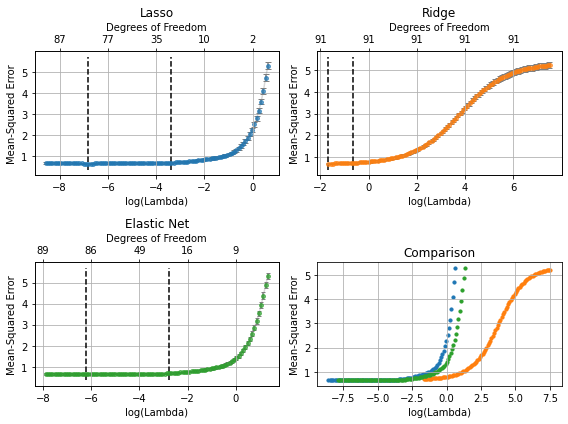

In [18]:
colors=["C0","C1","C2"]
f = plt.figure(figsize=(8,6))
f.add_subplot(2,2,1)
mi_cvglmnetPlot(cvFits[0],capsize=3,mcol=colors[0])
plt.title("Lasso")
f.add_subplot(2,2,2)
mi_cvglmnetPlot(cvFits[1],capsize=2,mcol=colors[1])
plt.title("Ridge")
f.add_subplot(2,2,3)
mi_cvglmnetPlot(cvFits[2],capsize=2,mcol=colors[2])
plt.title("Elastic Net")
f.add_subplot(2,2,4)
for i in range(3):
    plt.scatter( np.log(cvFits[i]['lambdau']), cvFits[i]['cvm'], c=colors[i],label=names2[i],s=10)
plt.xlabel('log(Lambda)')
plt.ylabel(cvFits[0]["name"])
plt.grid()
plt.title("Comparison")
plt.tight_layout()
plt.savefig(os.path.join("tarea","regularized.pdf"))
plt.show()

In [19]:
regModels = [X.loc[:,np.transpose(cvglmnetCoef(fit))[0][1:]!=0] for fit in cvFits]

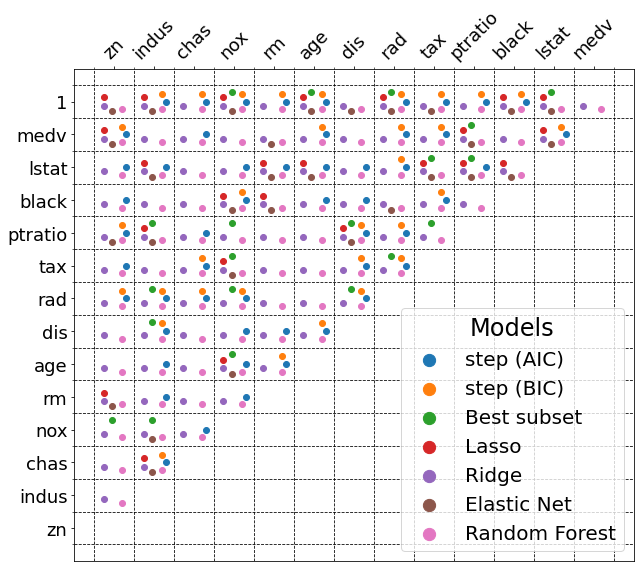

In [20]:
fig,ax = plt.subplots(figsize=(9,8))
variables = df.drop("crim",axis=1).columns.to_list()
nvars = len(variables)
ax.xaxis.set_ticks(range(nvars))
ax.xaxis.set_ticklabels(variables,fontsize=18,rotation=45)
ax.xaxis.set_ticks(np.arange(-0.5,nvars+0.6),minor=True)
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks(range(nvars+1))
ax.yaxis.set_ticklabels(variables+["1"],fontsize=18)
ax.yaxis.set_ticks(np.arange(-0.5,nvars+1.6),minor=True)
ax.set_xlim(-1,nvars)
ax.set_ylim(-1,nvars+1)
models = [aicMod,bicMod,subsetMod] + regModels + [X]
nmodels = len(models)
markers = ["o" for i in range(nmodels)]
for i, mod in enumerate(models):
    xs=[]
    ys=[]
    for var in mod.columns:
        decomp = var.split(":")
        if len(decomp)==1:
            xs.append(0.3*np.cos(2*np.pi*i/nmodels) + variables.index(var))
            ys.append(0.3*np.sin(2*np.pi*i/nmodels) + nvars)
        elif len(decomp)==2:
            xs.append(0.3*np.cos(2*np.pi*i/nmodels) + variables.index(decomp[0]))
            ys.append(0.3*np.sin(2*np.pi*i/nmodels) + variables.index(decomp[1]))
    ax.scatter(xs,ys,label=names[i])
lgnd = ax.legend(loc="lower right",fontsize=20,title="Models")
plt.setp(lgnd.get_title(),fontsize=24)
for handle in lgnd.legendHandles:
    handle.set_sizes([150])
ax.grid(which="minor",linestyle="--",alpha=1,color="k")
ax.plot(label="modelo")
plt.tight_layout()
plt.savefig(os.path.join("tarea","variables.pdf"))
plt.show()

In [21]:
details1 = ["-","-","Selección hacia adelante (forward), iniciando en el mejor modelo de 1 variable y finalizando en el mejor con 20"]
details2 = ["Se usó lambda_1se = {0}".format(round(lambMins[i],4)) for i in range(3)]
details = details1 + details2 + ["NBoot = 100, m = {0}".format(X.shape[1])]
details

['-',
 '-',
 'Selección hacia adelante (forward), iniciando en el mejor modelo de 1 variable y finalizando en el mejor con 20',
 'Se usó lambda_1se = 0.0286',
 'Se usó lambda_1se = 0.5232',
 'Se usó lambda_1se = 0.0521',
 'NBoot = 100, m = 91']

In [22]:
modDetails = pd.DataFrame.from_dict({"model":names,"Dfs":dfs,"details":details})
modDetails.index = range(1,len(names)+1)
tab = "c|p{3cm}|c"
for name in modDetails.columns[2:]:
    tab += "|p{6cm}"
with pd.option_context("max_colwidth", 1000):
    modDetails.to_latex(buf = os.path.join("tarea","modDetails.tex"),float_format="{:0.4f}".format,column_format=tab)

In [23]:
ds = [drop1(sm.OLS,aicMod,y,aic),drop1(sm.OLS,bicMod,y,bic),drop1(sm.OLS,subsetMod,y,rss)]
aux = ["aicDrop","bicDrop","subDrop"]
tab = "c|c|c"
for j,d1 in enumerate(ds):
    for i,d in enumerate(np.split(d1,[int(d1.shape[0]/2)])):
        d.to_latex(buf=os.path.join("tarea","{1}{0}.tex".format(i,aux[j])),float_format="{:0.4f}".format,column_format=tab,index=False)

In [24]:
d1 = drop1(sm.OLS,bicMod,y,bic)
tab = "c|p{2cm}|p{2cm}"
for i,d in enumerate(np.split(d1,[int(d1.shape[0]/2)])):
    d.to_latex(buf=os.path.join("tarea","bicDrop{0}.tex".format(i)),float_format="{:0.4f}".format,column_format=tab,index=False)

In [25]:
models = [aicMod,bicMod,subsetMod]
aux = ["aicDrop","bicDrop","subDrop"]
for i,mod in enumerate(models):
    d1 = drop1(sm.OLS,mod,y,aic)
    d2 = drop1(sm.OLS,mod,y,rss)
    d3 = drop1(sm.OLS,mod,y,F_test_P_value)
    d = pd.concat([d1,d2.iloc[:,1:],d3.iloc[:,[1]]],axis=1)
    tab = ""
    for c in d.columns:
        tab += "|c"
    tab = tab[1:]
    d.to_latex(buf=os.path.join("tarea","{0}.tex".format(aux[i])),float_format="{:0.4f}".format,column_format=tab,index=False,longtable=True)